# Logistic Regression

In [125]:
## installing the 'wooldridge' package if not previously installed
if (!require(wooldridge)) install.packages('wooldridge')

data(mroz)

##  Obs:   753

##  1. inlf                     =1 if in labor force, 1975
##  2. hours                    hours worked, 1975
##  3. kidslt6                  # kids < 6 years
##  4. kidsge6                  # kids 6-18
##  5. age                      woman's age in yrs
##  6. educ                     years of schooling
##  7. wage                     estimated wage from earns., hours
##  8. repwage                  reported wage at interview in 1976
##  9. hushrs                   hours worked by husband, 1975
## 10. husage                   husband's age
## 11. huseduc                  husband's years of schooling
## 12. huswage                  husband's hourly wage, 1975
## 13. faminc                   family income, 1975
## 14. mtr                      fed. marginal tax rate facing woman
## 15. motheduc                 mother's years of schooling
## 16. fatheduc                 father's years of schooling
## 17. unem                     unem. rate in county of resid.
## 18. city                     =1 if live in SMSA
## 19. exper                    actual labor mkt exper
## 20. nwifeinc                 (faminc - wage*hours)/1000
## 21. lwage                    log(wage)
## 22. expersq                  exper^2

## specifying the outcome variable (y) and original predictors (X)
outcome <- "inlf"
predictors <- c("kidslt6", "kidsge6", "age", "educ","exper", "hushrs", "husage", "huseduc","huswage", 
    "nwifeinc","mtr","unem","city")

## Load the data and remove NAs
data("mroz", package = "wooldridge")
mroz.copy <- subset(mroz, select = c(outcome, predictors))

In [87]:
## installing the 'tidyverse' package if not previously installed
if (!require(tidyverse)) install.packages('tidyverse')

## installing the 'caret' package if not previously installed
if (!require(caret)) install.packages('caret')

theme_set(theme_bw())

## split the data into training and test set
set.seed(42)
training.samples <- mroz.copy$inlf %>% 
  createDataPartition(p = 0.8, list = FALSE)
train.data  <- mroz.copy[training.samples, ]
test.data <- mroz.copy[-training.samples, ]

In [88]:
## fit the model
model <- glm( inlf ~., data = train.data, family = binomial)

## printing the model estimated coefficients
coef(model)

## making predictions
probabilities <- model %>% predict(test.data, type = "response")
predicted.classes <- ifelse(probabilities > 0.5, 1, 0)

## Model accuracy
mean(predicted.classes == test.data$inlf)

(Intercept)       kidslt6       kidsge6           age          educ 
 2.259511e+01 -1.139269e+00  2.505065e-01 -9.066845e-02  1.857566e-01 
        exper        hushrs        husage       huseduc       huswage 
 1.051856e-01 -7.987842e-04  1.035604e-02 -5.979270e-02 -1.952675e-01 
     nwifeinc           mtr          unem          city 
-9.772453e-02 -2.383083e+01 -2.165558e-03  1.172546e-02

[1] 0.8133333

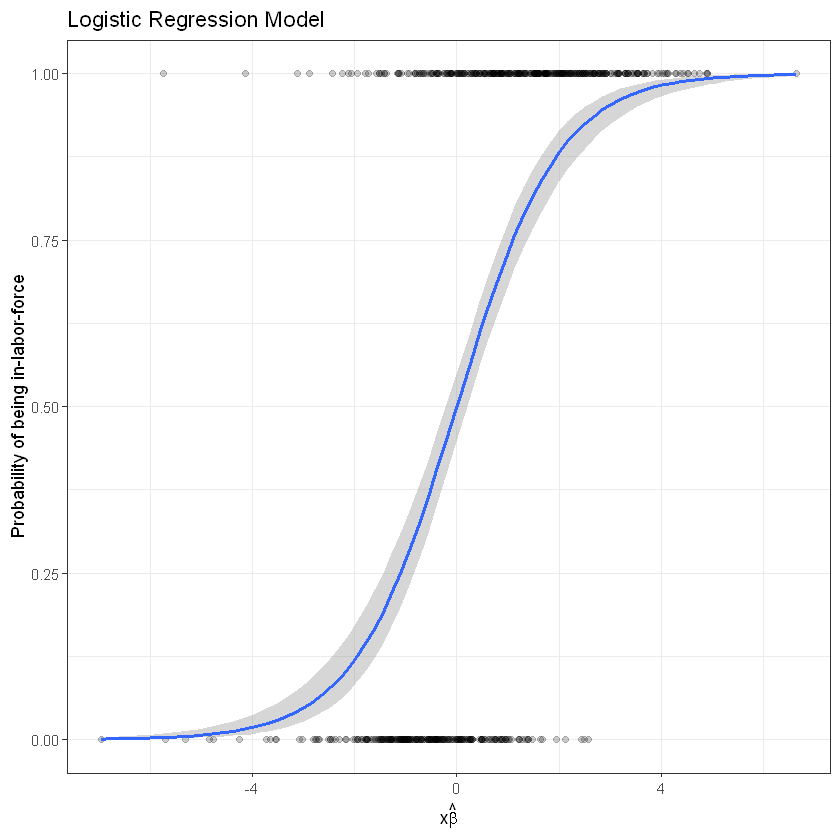

In [89]:
xb <- predict(model, type = "link")

data.frame(train.data,xb=xb) %>%
      ggplot(aes(xb, inlf)) +
      geom_point(alpha = 0.2) +
      geom_smooth(method = "glm", method.args = list(family = "binomial")) +
      labs(
        title = "Logistic Regression Model", 
        x = bquote(x * hat(beta)),
        y = "Probability of being in-labor-force"
        )

In [126]:
## demeaning all predictors, renaming them and saving their variable names
x <- scale(model.matrix(inlf ~ .-city, mroz.copy)[, -1], center = TRUE, scale = FALSE)
colnames(x) <- paste("d_", colnames(x), sep = "")
drops <- colnames(x)

## attaching the demeaned predictors to a copy of the original data set
mroz.copy <- cbind(mroz.copy, x)

d.predictors <- paste('(',paste(drops, collapse = "+"),')^2',sep="")
xx <- model.matrix(lm(as.formula(paste0(outcome, "~", d.predictors)),data=mroz.copy))[,-1]

mroz.copy <- cbind(mroz.copy[, !(colnames(mroz.copy) %in% drops)],xx[,!(colnames(xx) %in% drops)])

## split the data into training and test set
set.seed(42)
training.samples <- mroz.copy$inlf %>% 
  createDataPartition(p = 0.8, list = FALSE)
train.data  <- mroz.copy[training.samples, ]
test.data <- mroz.copy[-training.samples, ]

In [127]:
## for high-dimensional estimation
if (!require(glmnet)) install.packages("glmnet")
library(glmnet)

## creating the feature matrix & outcome for the train data
x.train <- as.matrix(train.data[,-1])
y.train <- train.data$inlf

## creating the response variable for the train data
x.test <- as.matrix(test.data[,-1])
y.test <- test.data$inlf

[1] 0.008655952

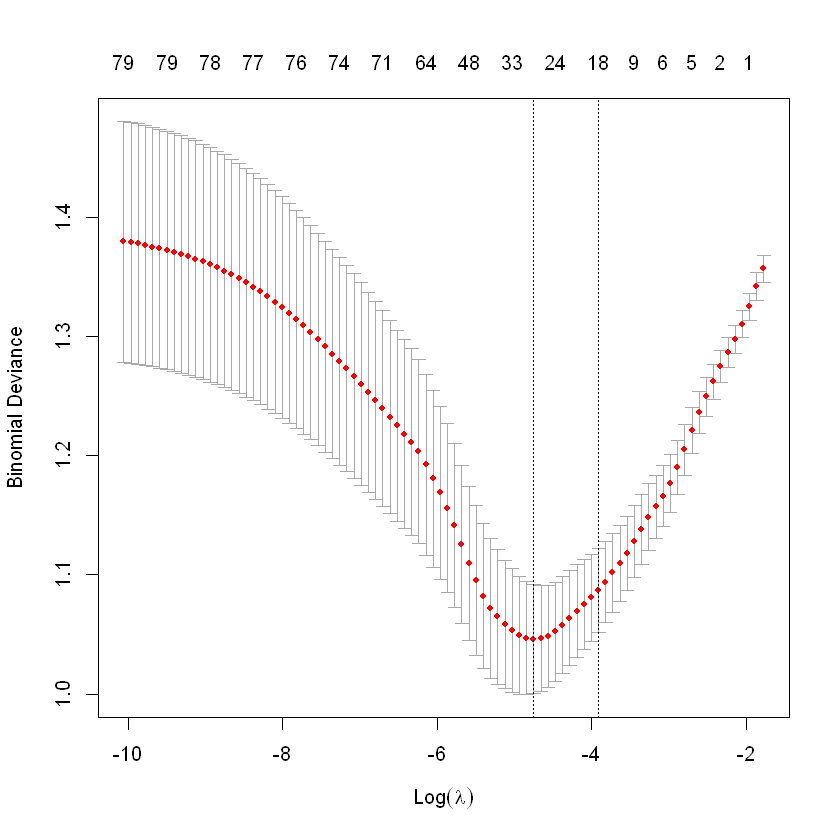

In [92]:
set.seed(42)
cv.lasso <- cv.glmnet(x.train, y.train, alpha = 1, family = "binomial")
plot(cv.lasso)

cv.lasso$lambda.min

In [93]:
coef(cv.lasso, cv.lasso$lambda.min)

80 x 1 sparse Matrix of class "dgCMatrix"
                                 1
(Intercept)           1.713181e+01
kidslt6              -6.420894e-01
kidsge6               9.459160e-02
age                  -7.679362e-02
educ                  1.130444e-01
exper                 1.137793e-01
hushrs               -6.524899e-04
husage                .           
huseduc              -5.406405e-04
huswage              -1.543853e-01
nwifeinc             -5.917426e-02
mtr                  -1.788061e+01
unem                  .           
city                  .           
d_kidslt6:d_kidsge6   .           
d_kidslt6:d_age       4.889665e-02
d_kidslt6:d_educ      2.363078e-02
d_kidslt6:d_exper     .           
d_kidslt6:d_hushrs    .           
d_kidslt6:d_husage    .           
d_kidslt6:d_huseduc   .           
d_kidslt6:d_huswage  -2.029816e-03
d_kidslt6:d_nwifeinc  .           
d_kidslt6:d_mtr       1.625426e+00
d_kidslt6:d_unem      1.342908e-02
d_kidsge6:d_age       .           
d_kidsge6:d_e

In [99]:
# Final model with optimal lambda
lasso.model <- glmnet(x.train, y.train, alpha = 1, family = "binomial",
                      lambda = cv.lasso$lambda.min)
probabilities <- lasso.model %>% predict(newx = x.test)
predicted.classes <- ifelse(probabilities > 0.5, "1", "0")
# Model accuracy rate
mean(predicted.classes == y.test)

[1] 0.8066667

In [157]:
## for easy machine learning workflow
if (!require(caret)) install.packages("caret")
library(caret)

## for easy machine learning workflow
if (!require(MLmetrics)) install.packages("MLmetrics")
library(MLmetrics)



## setting up a grid range of lambda values
lambda <- 10^seq(-3, 3, length = 100)

## LASSO: building the model
set.seed(42)
lasso <- train(inlf ~ ., data = data.frame(inlf = factor(train.data$inlf,labels=c("no","yes")), train.data[,-1]), method = "glmnet", 
    trControl = trainControl("cv",number = 10,summaryFunction = prSummary,classProbs = T), tuneGrid = expand.grid(alpha = 1, 
        lambda = lambda),family="binomial",metric="Accuracy")

## LASSO: model coefficients
coef(lasso$finalModel, lasso$bestTune$lambda)

## LASSO: making predictions
probabilities <- lasso %>% predict(data.frame(lprice = factor(test.data$inlf,labels=c("no","yes")), test.data[,-1]))

# Model accuracy rate
mean(as.numeric(probabilities)==y.test+1)

Warning message in train.default(x, y, weights = w, ...):
"The metric "Accuracy" was not in the result set. AUC will be used instead."Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."

80 x 1 sparse Matrix of class "dgCMatrix"
                                 1
(Intercept)           2.083798e+01
kidslt6              -7.184792e-01
kidsge6               1.322321e-01
age                  -8.403366e-02
educ                  1.257681e-01
exper                 1.225910e-01
hushrs               -8.461640e-04
husage                .           
huseduc              -5.756045e-03
huswage              -1.965878e-01
nwifeinc             -7.021137e-02
mtr                  -2.175845e+01
unem                  .           
city                  .           
d_kidslt6.d_kidsge6   .           
d_kidslt6.d_age       4.472044e-02
d_kidslt6.d_educ      7.810394e-02
d_kidslt6.d_exper    -1.366258e-02
d_kidslt6.d_hushrs    .           
d_kidslt6.d_husage    1.118202e-02
d_kidslt6.d_huseduc   .           
d_kidslt6.d_huswage  -1.721184e-02
d_kidslt6.d_nwifeinc  .           
d_kidslt6.d_mtr       2.548683e+00
d_kidslt6.d_unem      1.966759e-02
d_kidsge6.d_age       .           
d_kidsge6.d_e

[1] 0.8266667